This notebook is from Rafael, and it doesn't run w/ my singularity setup, so I'm going to try using his conda env.

`source /gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/bin/activate py3`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot

In [2]:
filename="/u/ki/nhartman/gpfs/hh4b-resolved-reconstruction/data16_topo_2016triggers.root"
tree = uproot.open(filename)["fullmassplane"]

In [3]:
data16 = tree.pandas.df()

In [4]:
to_log = [ 'pT_4', 'pT_2', 'dRjj_1', 'dRjj_2', 'pt_hh' ]

In [5]:
for tl in to_log:
    if str(tl+'_log') in data16.keys():
        print(tl, "already in dataset, skipping")
        continue
    data16[tl+'_log'] = np.log(data16[tl])

In [6]:
sort_rw_cols = ['pT_4_log', 'pT_2_log', 'eta_i', 'dRjj_1_log', 'dRjj_2_log', 'njets', 'pt_hh_log']

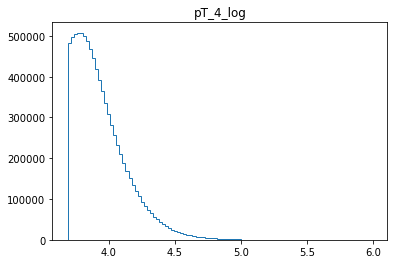

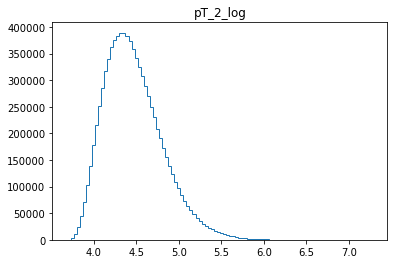

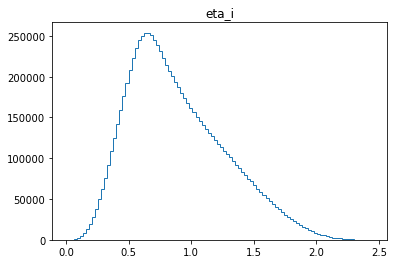

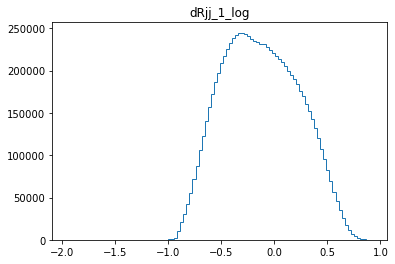

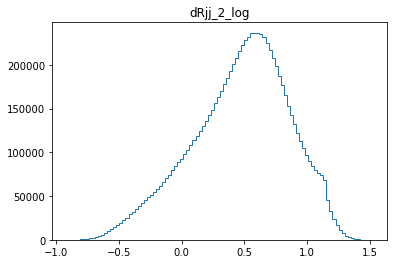

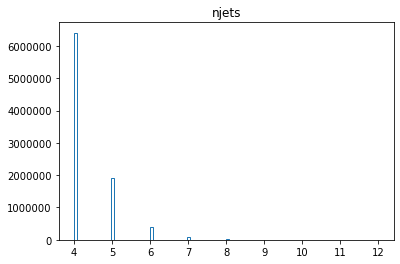

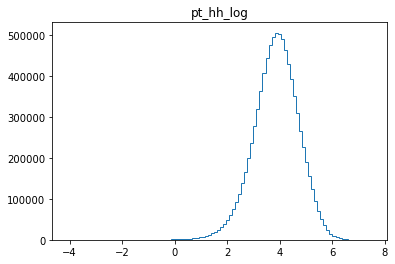

In [7]:
for rw in sort_rw_cols:
    plt.figure()
    plt.hist(data16[rw], bins=100, histtype='step')
    plt.title(rw)
    plt.show()

In [8]:
original = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 2),sort_rw_cols]
target = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 2),sort_rw_cols]

In [9]:
original_cr = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 1),sort_rw_cols]
target_cr = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 1),sort_rw_cols]

In [10]:
original_mass = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 2),"m_hh"]
target_mass = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 2),"m_hh"]

In [11]:
original_mass_cr = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 1),"m_hh"]
target_mass_cr = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 1),"m_hh"]

In [12]:
original_mass_corr = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 2),"m_hh_cor"]
target_mass_corr = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 2),"m_hh_cor"]

In [13]:
original_mass_corr_cr = data16.loc[(data16.ntag == 2)&(data16.kinematic_region == 1),"m_hh_cor"]
target_mass_corr_cr = data16.loc[(data16.ntag >= 4)&(data16.kinematic_region == 1),"m_hh_cor"]

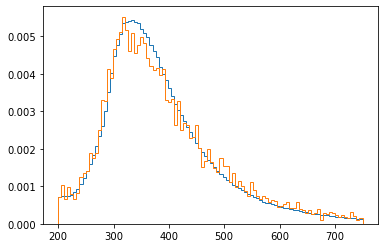

In [14]:
plt.figure()
plt.hist(original_mass, bins=100, histtype='step', range=(200,750), density=1, label='original')
plt.hist(target_mass, bins=100, histtype='step', range=(200,750), density=1, label='target')
plt.show()

In [15]:
X_all = pd.concat((original, target), ignore_index=True).values

In [16]:
Y_all = []
for _df, ID in [(original,1), (target, 0)]:
    Y_all.extend([ID] * _df.shape[0])
Y_all = np.array(Y_all)

In [17]:
print('split')
from sklearn.model_selection import train_test_split

split


In [18]:
ix = range(X_all.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
X_train, X_test, Y_train, Y_test, ix_train, ix_test = train_test_split(
    X_all, Y_all, ix, train_size=0.6)

In [19]:
print('scale')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scale


In [20]:
import keras.backend as K

Using TensorFlow backend.


In [21]:
def louppe_loss(y_true, y_pred):
    # Our loss
    return (y_true * (K.sqrt(K.exp(y_pred))) + 
            (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred))))

In [22]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input

In [23]:
X_all.shape

(1571139, 7)

In [25]:
inputs = Input(shape=(X_all.shape[1], ))
hidden = Dense(20, activation='relu')(inputs)
hidden = Dense(20, activation='relu')(hidden)
hidden = Dense(20, activation='relu')(hidden)
outputs = Dense(1, activation='linear')(hidden)

model = Model(inputs, outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss=louppe_loss, metrics=['accuracy'], optimizer="adam")

In [28]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [29]:
history = model.fit(X_train, Y_train,
                        callbacks = [
                                EarlyStopping(monitor='val_loss', patience=50, verbose=True),
                                ModelCheckpoint('current_model.h5', monitor='val_loss', verbose=True, save_best_only=True) ],
                                epochs=50,
                                validation_split = 0.2,
                                batch_size=1024,
                       )

Instructions for updating:
Use tf.cast instead.
Train on 754146 samples, validate on 188537 samples
Epoch 1/50
754146/754146 [==============================] - 6s 8us/step - loss: 0.2044 - acc: 6.7494e-04 - val_loss: 0.1556 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.15563, saving model to current_model.h5
Epoch 2/50
754146/754146 [==============================] - 4s 5us/step - loss: 0.1503 - acc: 0.0000e+00 - val_loss: 0.1522 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 0.15563 to 0.15217, saving model to current_model.h5
Epoch 3/50
754146/754146 [==============================] - 4s 6us/step - loss: 0.1482 - acc: 0.0000e+00 - val_loss: 0.1513 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.15217 to 0.15129, saving model to current_model.h5
Epoch 4/50
754146/754146 [==============================] - 4s 6us/step - loss: 0.1476 - acc: 0.0000e+00 - val_loss: 0.1507 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 0.15129 to 0.

In [30]:
yhat_orig = model.predict( scaler.transform(original.values), batch_size=1024 )
yhat_targ = model.predict( scaler.transform(target.values), batch_size=1024 )

In [31]:
yhat_orig_cr = model.predict( scaler.transform(original_cr.values), batch_size=1024 )
yhat_targ_cr = model.predict( scaler.transform(target_cr.values), batch_size=1024 )

In [32]:
print(yhat_orig)

[[-5.171118 ]
 [-5.2963476]
 [-6.418849 ]
 ...
 [-3.1419232]
 [-4.5773544]
 [-4.593339 ]]


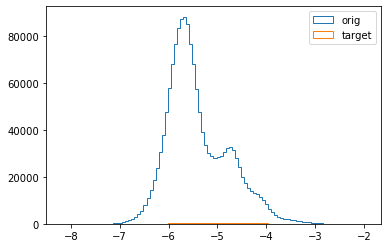

In [33]:
plt.figure()
plt.hist((yhat_orig), bins=100, histtype='step', label='orig')
plt.hist((yhat_targ), bins=100, histtype='step', label='target')
plt.legend()
plt.show()

In [36]:
# plt.figure()
# plt.hist(yhat_orig_transf, bins=100, histtype='step', label='orig')
# # plt.hist(np.log(yhat_targ), bins=100, histtype='step', label='target')
# plt.legend()
# plt.show()

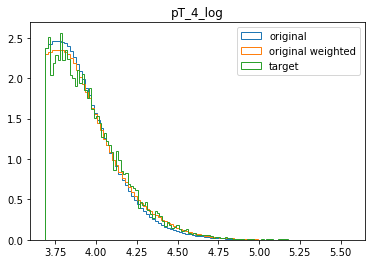

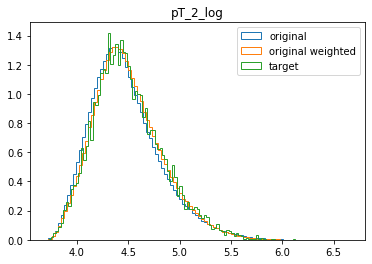

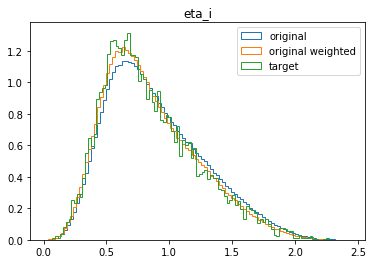

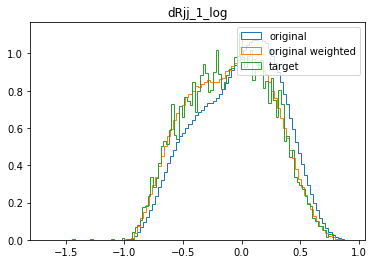

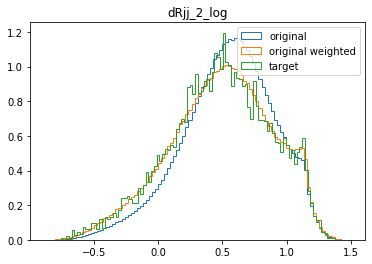

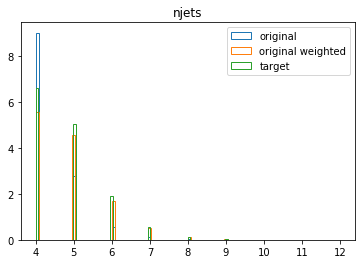

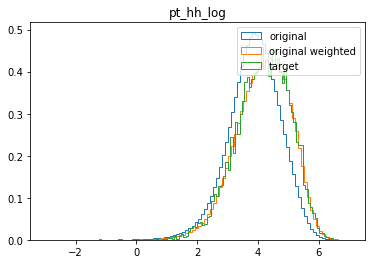

In [35]:
for rw in sort_rw_cols:
    plt.figure()
    plt.hist(original[rw], bins=100, density=1, histtype='step', label='original')
    plt.hist(original[rw], bins=100, density=1, histtype='step', weights=np.exp(yhat_orig), label='original weighted')
    plt.hist(target[rw], bins=100, density=1, histtype='step', label='target')
    plt.title(rw)
    plt.legend()
    plt.show()

In [37]:
for kk in data16.keys():
    print(kk)

run_number
event_number
mc_sf
ntag
njets
nValidPairs
kinematic_region
m_hh
pt_hh
X_wt
m_hh_cor
m_h1
E_h1
pT_h1
eta_h1
phi_h1
dRjj_h1
m_h2
E_h2
pT_h2
eta_h2
phi_h2
dRjj_h2
m_h1_j1
E_h1_j1
pT_h1_j1
eta_h1_j1
phi_h1_j1
tag_h1_j1
angle_h1_j1
m_h1_j2
E_h1_j2
pT_h1_j2
eta_h1_j2
phi_h1_j2
tag_h1_j2
angle_h1_j2
m_h2_j1
E_h2_j1
pT_h2_j1
eta_h2_j1
phi_h2_j1
tag_h2_j1
angle_h2_j1
m_h2_j2
E_h2_j2
pT_h2_j2
eta_h2_j2
phi_h2_j2
tag_h2_j2
angle_h2_j2
pT_4
pT_2
eta_i
dRjj_1
dRjj_2
pT_4_log
pT_2_log
dRjj_1_log
dRjj_2_log
pt_hh_log


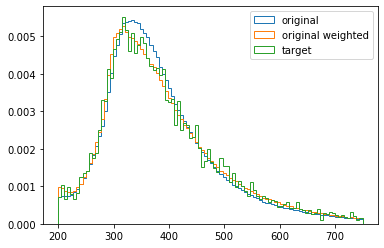

In [38]:
plt.figure()
plt.hist(original_mass, bins=100, histtype='step', range=(200,750), density=1, label='original')
plt.hist(original_mass, bins=100, histtype='step', range=(200,750), density=1, weights=np.exp(yhat_orig), label='original weighted')
plt.hist(target_mass, bins=100, histtype='step', range=(200,750), density=1, label='target')
plt.legend()
plt.show()

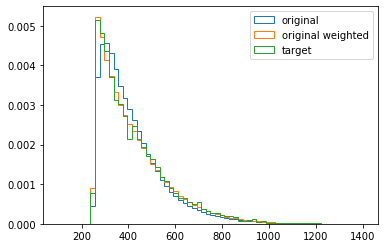

In [39]:
plt.figure()
plt.hist(original_mass_corr, bins=66, histtype='step', range=(100 , 1400), density=1, label='original')
plt.hist(original_mass_corr, bins=66, histtype='step', range=(100 , 1400), density=1, weights=np.exp(yhat_orig), label='original weighted')
plt.hist(target_mass_corr, bins=66, histtype='step', range=(100 , 1400), density=1, label='target')
plt.legend()
plt.show()

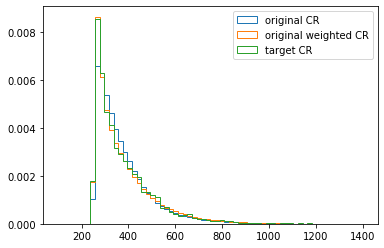

In [40]:
plt.figure()
plt.hist(original_mass_corr_cr, bins=66, histtype='step', range=(100 , 1400), density=1, label='original CR')
plt.hist(original_mass_corr_cr, bins=66, histtype='step', range=(100 , 1400), density=1, weights=np.exp(yhat_orig_cr), label='original weighted CR')
plt.hist(target_mass_corr_cr, bins=66, histtype='step', range=(100 , 1400), density=1, label='target CR')
plt.legend()
plt.show()

In [ ]:
print("done!")